# Notebook for calibration curve

Read `train.csv` from the [Titanic dataset at Kaggle](https://www.kaggle.com/c/titanic/data)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import model_selection

titanic = pd.read_csv('train.csv')

titanic.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## Preprocessing
Check if there is NULL anywhere.

In [2]:
titanic.Age.isnull().sum()

177

In [3]:
titanic.Sex.isnull().sum()

0

In [4]:
titanic.Survived.isnull().sum()

0

Make sure the column Age is imputed with mean (not stratified).

In [5]:
fitted_age_imputer = preprocessing.Imputer(axis=1).fit(titanic['Age'].values)
titanic['Age_imputed'] = fitted_age_imputer.transform(titanic['Age']
                                                            .values
                                                            .reshape(1, -1)).transpose()

In [6]:
titanic['Sex_coded'] = np.where(titanic.Sex == 'female', 1, 0)

In [7]:
titanic.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_imputed,Sex_coded
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,22.0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,38.0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,26.0,1


Make a training/validation split on the data.

In [8]:
from sklearn import model_selection
feature_cols = ['Age_imputed', 'Sex_coded']
feature_train, feature_test, label_train, label_test = (model_selection
                                                              .train_test_split(titanic[feature_cols],
                                                                                titanic.Survived,
                                                                                test_size=0.2,
                                                                                random_state=1))

Make sure the column Sex is coded as discrete variables before feeding into logistic regression.

## Train models
First, train a logistic regression model and predict on validation set.

In [9]:
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression().fit(X=feature_train,y=label_train)

logreg_prediction = logreg_model.predict_proba(feature_test)

Then, train a random forest model and predict on validation set

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=1234).fit(X=feature_train, y=label_train)

rf_prediction = rf_model.predict_proba(feature_test)

The positive class probability is in the second column.

In [11]:
print(logreg_prediction[:5])

[[ 0.30439638  0.69560362]
 [ 0.80800552  0.19199448]
 [ 0.24986814  0.75013186]
 [ 0.271399    0.728601  ]
 [ 0.23373554  0.76626446]]


## Calibration plot

Now we have class probabilities and labels, we can compute the bins for calibration plot

In [12]:
from sklearn.calibration import calibration_curve

`sklearn.calibration.calibration_curve` returns the x,y coordinates for my logistic regression model predictions on the calibration plot.

In [13]:
logreg_y, logreg_x = calibration_curve(label_test, logreg_prediction[:,1], n_bins=10)

Note that although I asked for 10 bins, there are 6 bins that don't have any data because I picked a simple model using only two features and have less than 200 points of data in the validation set.

In [14]:
print([logreg_y, logreg_x])

[array([ 0.24719101,  0.08      ,  0.8       ,  0.75      ]), array([ 0.18667202,  0.21127751,  0.68840625,  0.73992411])]


Similarly, compute the coordinates for random forest model.

In [15]:
rf_y, rf_x = calibration_curve(label_test, rf_prediction[:,1], n_bins=10)

Plot the two calibration curves, where I also [add a y=x reference line based on a StackOverflow answer](https://stackoverflow.com/questions/40516661/adding-line-to-scatter-plot-using-pythons-matplotlib).

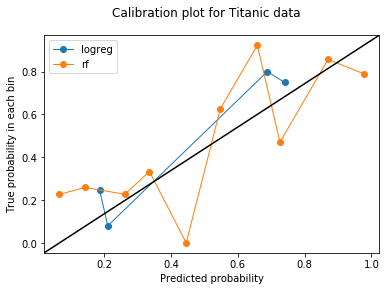

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

# calibration curves
fig, ax = plt.subplots()
plt.plot(logreg_x,logreg_y, marker='o', linewidth=1, label='logreg')
plt.plot(rf_x, rf_y, marker='o', linewidth=1, label='rf')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for Titanic data')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show() # it's not rendered correctly on GitHub, check blog post for actual pic

In [17]:
fig.savefig('python-calibration.png', dpi=100)

### Find the number of points in the bins

In [18]:
def bin_total(y_true, y_prob, n_bins):
    bins = np.linspace(0., 1. + 1e-8, n_bins + 1)
    binids = np.digitize(y_prob, bins) - 1
    return np.bincount(binids, minlength=len(bins))

For logistic regression:

In [19]:
bin_total(label_test, logreg_prediction[:,1], n_bins=10)

array([ 0, 89, 25,  0,  0,  0,  5, 60,  0,  0,  0], dtype=int64)

For random forest:

In [20]:
bin_total(label_test, rf_prediction[:,1], n_bins=10)

array([53, 27, 22,  9,  4,  8, 13, 17,  7, 19,  0], dtype=int64)

## Cross-validated version
Use 5-fold cross-validation instead, and take the average of all of my data to make the calibration plot.

In [21]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1234)

# store probability predictions and true labels here
logreg_kfold_probability = []
rf_kfold_probability = []
kfold_true_label = []

Train and predict on each split.

In [22]:
for train_index, validate_index in kf.split(titanic):
    kfold_train, kfold_validate = titanic.iloc[train_index], titanic.iloc[validate_index]
    
    train_features = kfold_train[feature_cols]
    train_labels = kfold_train['Survived']
    validate_features = kfold_validate[feature_cols]
    validate_labels = kfold_validate['Survived']
    
    logreg_model = LogisticRegression().fit(X=train_features ,y=train_labels)
    rf_model = RandomForestClassifier().fit(X=train_features, y=train_labels)
    
    logreg_kfold_probability.append(logreg_model.predict_proba(validate_features)[:,1])
    rf_kfold_probability.append(rf_model.predict_proba(validate_features)[:,1])
    kfold_true_label.append(validate_labels)
    

Concatenate the results and compute bins for calibration curves.

In [23]:
logreg_kfold_probability_stacked = np.hstack(logreg_kfold_probability)
rf_kfold_probability_stacked = np.hstack(rf_kfold_probability)
kfold_true_label_stacked = np.hstack(kfold_true_label)
                                     
logreg_y, logreg_x = calibration_curve(kfold_true_label_stacked, logreg_kfold_probability_stacked, n_bins=10)
rf_y, rf_x = calibration_curve(kfold_true_label_stacked, rf_kfold_probability_stacked, n_bins=10)

Plot calibration curves

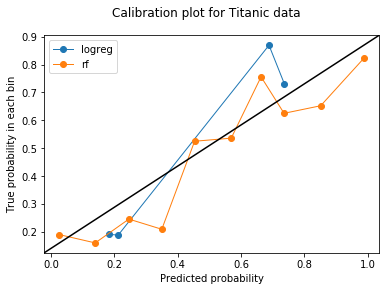

In [24]:
# calibration curves
fig, ax = plt.subplots()
plt.plot(logreg_x,logreg_y, marker='o', linewidth=1, label='logreg')
plt.plot(rf_x, rf_y, marker='o', linewidth=1, label='rf')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for Titanic data')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show() # it's not rendered correctly on GitHub, check blog post for actual pic

In [25]:
fig.savefig('python-calibration-cv.png', dpi=100)

In [26]:
bin_total(kfold_true_label_stacked, rf_kfold_probability_stacked, n_bins=10)

array([164, 226,  98,  48,  61,  28,  41,  72,  46, 107,   0], dtype=int64)